## IBTrACS diagnostic

How many samples? How many valid samples? etc...

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl


# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
from scipy.interpolate import interp1d
from datetime import datetime

# Custom
import dataUtils    as du
import pytorchUtils as pu

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
input_variables    = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34'] 
target_variable    = ['usa_rmw']
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'interp_thresh': 8, # if the gap between 2 valid sequences is less than interp_thresh, then linearly interpolate data
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'save_path':    '/home/arthur/results/TCsLifeMonitFromObs/ibtracs_diagnostic/', 
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]

# Convert to m/s and km units
ds_ibt['usa_wind'] *= 0.5144
ds_ibt['usa_r34']  *= 1.852
ds_ibt['usa_rmw']  *= 1.852

ds_ibt

<xarray.Dataset>
Dimensions:     (storm: 2293, date_time: 360, quadrant: 4)
Coordinates:
    time        (storm, date_time) datetime64[ns] ...
    lat         (storm, date_time) float32 ...
    lon         (storm, date_time) float32 ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables:
    usa_lon     (storm, date_time) float32 ...
    usa_lat     (storm, date_time) float32 ...
    usa_wind    (storm, date_time) float32 nan nan nan nan ... nan nan nan nan
    usa_r34     (storm, date_time, quadrant) float32 nan nan nan ... nan nan nan
    usa_rmw     (storm, date_time) float32 nan nan nan nan ... nan nan nan nan
    numobs      (storm) float32 ...
    sid         (storm) |S13 ...
    basin       (storm, date_time) |S2 ...
    name        (storm) |S128 ...
    usa_agency  (storm, date_time) |S32 ...
    iso_time    (storm, date_time) |S19 ...
    usa_status  (storm, date_time) |S2 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [5]:
### SAVE RAW DATASET

# for s in tqdm(range(len(ds_ibt['storm']))[:1]):
#     ds = ds_ibt.isel(storm=s)
#     du.save_ibt_sample(ds, path=PATHS['save_path'] + 'ibt{}_{}.png'.format(format(s, '04d'), str(ds['sid'].values)[2:-1]))

In [6]:
### FILTERS
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# Average by quadrant (R34 assumption)
ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True)
# By category
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_wind']
    if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
        ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # By latitude
# ds_ibt     = ds_ibt.where(np.abs(ds_ibt['lat']) <= 40) # Take some margin on latitude to take into account valid Rmax time series that overtake lat = 30°
# # By removing empty R34 time series
# # ds_ibt     = ds_ibt.where(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True).notnull()) 
# ds_ibt['usa_r34'] = ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True)
# # By agency
# ds_ibt     = ds_ibt.where(b'hurdat_atl' in ds_ibt['usa_agency'])
# # By category
# ds_ibt     = ds_ibt.where(ds_ibt['usa_wind'].max(dim='date_time', skipna=True) > 33) # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
# # First average on every quadrant
# # ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True)

# # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_rmw']
    # Longest valid sequence
    # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
    #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
    # Number of valid values
    if np.count_nonzero(~np.isnan(da)) < 24: # Count the number of valid usa_rmw values and filter it out if less than 24 values
        ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# Drop NaNs
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after filtering: ", len(ds_ibt['storm']))

100%|███████████████████████████████████████| 394/394 [00:00<00:00, 1067.72it/s]

Total samples after filtering:  143


In [7]:
# ### SAVE FILTERED DATASET

# for s in tqdm(range(len(ds_ibt['storm']))):
#     ds  = ds_ibt.isel(storm=s)
#     idx = np.where(~pd.isnull(ds['sid'].values))[0][0]
#     # du.save_ibt_sample(ds, path=PATHS['save_path'] + 'NA_dataset_filtered/ibt{}_{}.png'.format(format(s, '04d'), str(ds['sid'].values[idx])[2:-1]))
#     du.save_ibt_sample(ds, path=PATHS['save_path'] + 'NA_dataset_filtered/ibt{}_{}.png'.format(format(s, '04d'), str(ds['sid'].values)[2:-1]))

In [8]:
### Interpolate missing values if blank is less than 24 hrs (= 8 steps)
thresh = PARAMS['interp_thresh']

ds_ibt['usa_lon'] = ds_ibt['lon']
ds_ibt['usa_lat'] = ds_ibt['lat']

for param in ['usa_wind', 'usa_r34', 'usa_rmw']:
    for s in tqdm(range(len(ds_ibt['storm']))):
        ds = ds_ibt.isel(storm=s)

        first_valid_idx = np.where(~np.isnan(ds[param]))[0][0]
        nan_seq_lengths = np.diff(np.where(~np.isnan(ds[param]))[0])
        idxs_of_nan_seq = np.where(nan_seq_lengths > 1)
        if len(idxs_of_nan_seq[0]) > 0: # Check if list is empty
            for idx in idxs_of_nan_seq[0]:
                idx = int(idx)
                if nan_seq_lengths[idx] <= thresh:
                    y = [ds[param].values[first_valid_idx + idx], ds[param].values[first_valid_idx + idx + nan_seq_lengths[idx]]]
                    x = [0, 1]
                    f = interp1d(x, y) # Interpolator
                    xnew = np.linspace(0, 1, nan_seq_lengths[idx] + 1)
                    ds[param][first_valid_idx + idx:first_valid_idx + idx + nan_seq_lengths[idx] + 1] = f(xnew) # Interpolation 
                    # ds_ibt[param] = ds[param] # Assignation

100%|███████████████████████████████████████| 143/143 [00:00<00:00, 1040.93it/s]


In [9]:
# ### SAVE INTERPOLATED DATASET

# for s in tqdm(range(len(ds_ibt['storm']))):
#     ds  = ds_ibt.isel(storm=s)
#     # idx = np.where(~pd.isnull(ds['sid'].values))[0][0]
#     du.save_ibt_sample(ds, path=PATHS['save_path'] + 'NA_dataset_interpolated/ibt{}_{}.png'.format(format(s, '04d'), str(ds['sid'].values)[2:-1]))

In [10]:
### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# Both for RMW and R34
life_cyc_percent_thresh = 0.6

for s in tqdm(range(len(ds_ibt['storm']))):
        ds      = ds_ibt.isel(storm=s)
        # Compute life cycle length
        cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
        for param in ['usa_r34', 'usa_rmw']:
            # Compute length of longest valid sequence
            val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
            if val_len < life_cyc_percent_thresh * cyc_len:
                # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
                ds[param] *= np.nan
                
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after filtering: ", len(ds_ibt['storm']))

100%|████████████████████████████████████████| 143/143 [00:00<00:00, 663.55it/s]

Total samples after filtering:  115


In [11]:
# ### SAVE FINAL DATASET

# for s in tqdm(range(len(ds_ibt['storm']))):
#     ds  = ds_ibt.isel(storm=s)
#     # idx = np.where(~pd.isnull(ds['sid'].values))[0][0]
#     du.save_ibt_sample(ds, path=PATHS['save_path'] + 'NA_dataset_final/ibt{}_{}.png'.format(format(s, '04d'), str(ds['sid'].values)[2:-1]))

100%|███████████████████████████████████████| 115/115 [00:00<00:00, 1671.85it/s]


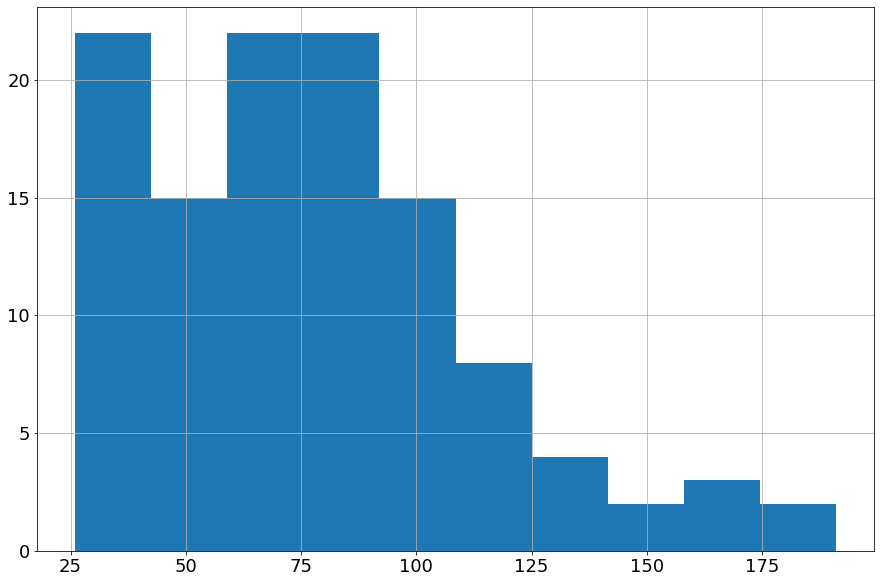

In [12]:
l = []

for s in tqdm(range(len(ds_ibt['storm']))):
    ds = ds_ibt.isel(storm=s)
    new = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds['usa_rmw']))[0]), axis=0)))
    l.append(new)
    
plt.hist(l);plt.grid()

In [13]:
### TESTS FOR PRESENTATION

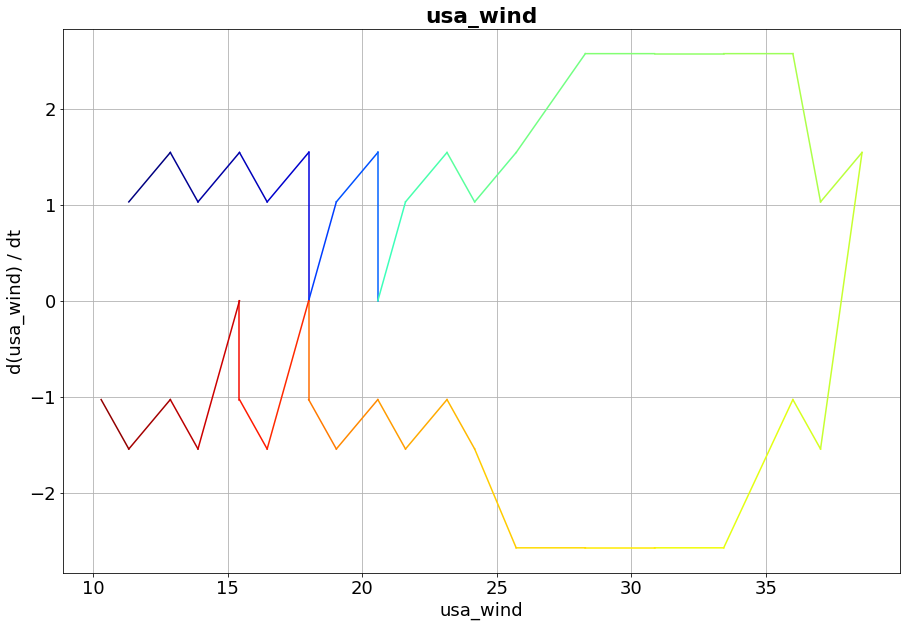

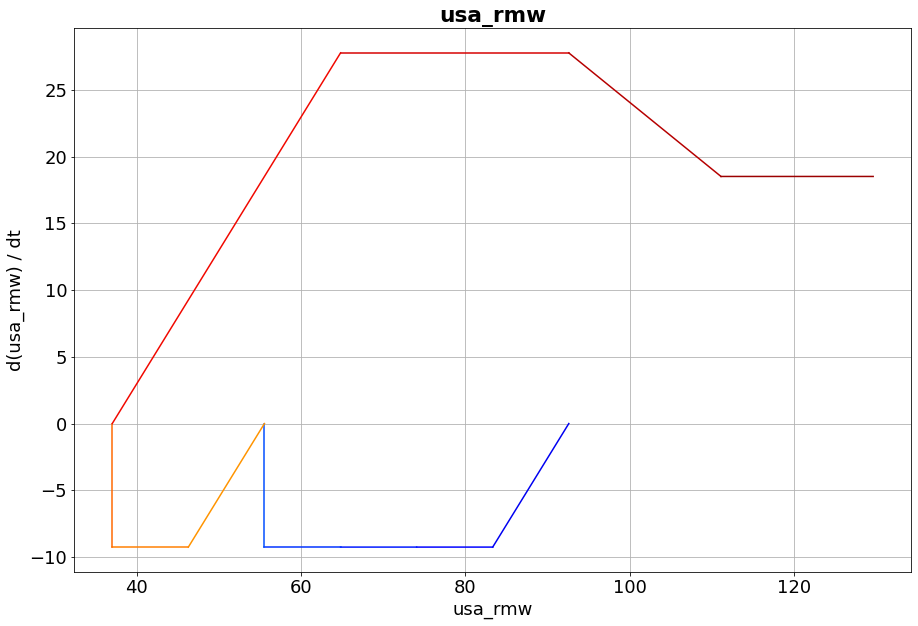

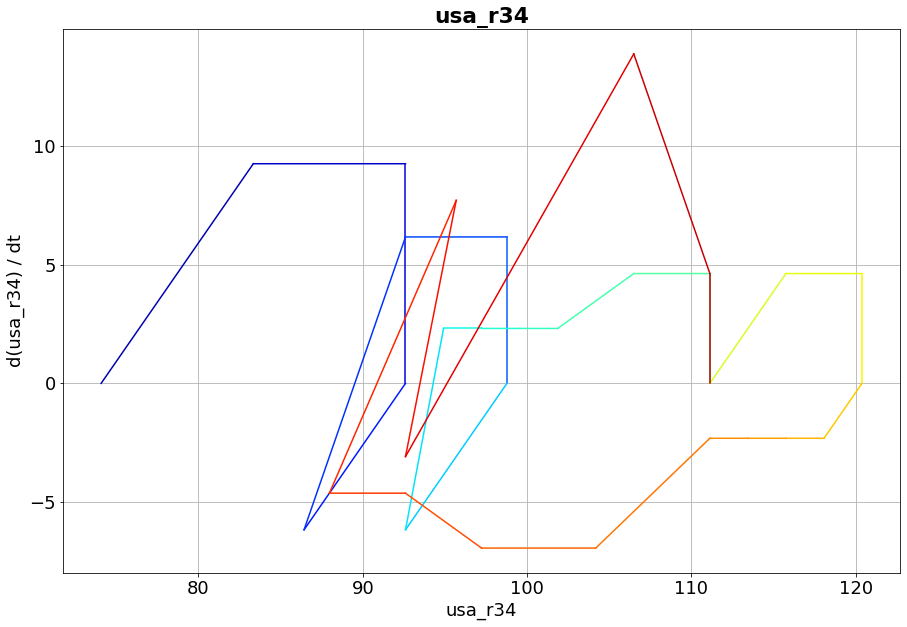

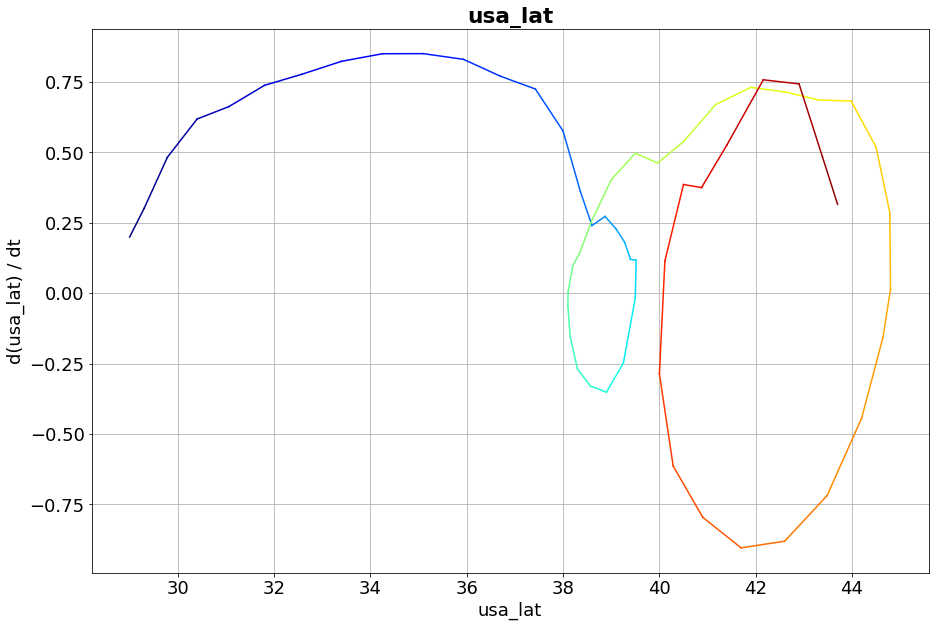

In [15]:
import matplotlib.cm as cm
def plot_colourline(x,y,c):
    c = cm.jet((c-np.nanmin(c))/(np.nanmax(c)-np.nanmin(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
    return

### PHASE PORTRAITS
params = ['usa_wind', 'usa_rmw', 'usa_r34', 'usa_lat']
for param in params:
    plt.title(param, weight='bold')
    for s in range(len(ds_ibt['storm']))[50:51]:
        da = ds_ibt.isel(storm=s)[param]
        # plt.plot(da[:-1], da.diff(dim='date_time'))
        # c = np.where(~np.isnan(np.array(da)))[0]
        idxs = np.array(da)
        idxs[~np.isnan(idxs)] =  np.where(~np.isnan(np.array(da)))[0]
        plot_colourline(da[1:].values, da.diff(dim='date_time').values, idxs[1:])
    plt.grid()
    plt.xlabel(param)
    plt.ylabel('d({}) / dt'.format(param))
    
    # Save
    # plt.savefig(PATHS['save_path'] + 'phase_portraits/{}'.format(param))
    plt.show()

In [16]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    f     = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at lat° latitude and assuming it's constant 
    return f

X = [] # shape (n_samples, n_features)
Y = [] # shape (n_samples, n_targets)

# For each storm, build X and y dataset.
for s in tqdm(range(len(ds_ibt.storm))):
    # Select storm
    ds = ds_ibt.isel(storm=s)
    # Add derivatives
    for p in ['usa_rmw', 'usa_r34', 'usa_wind']:
        ds['{}_diff'.format(p)]     = ds[p] * np.nan
        ds['{}_diff'.format(p)][1:] = ds[p].diff(dim='date_time')
    # Add Coriolis
    ds['fcor'] = coriolis(np.abs(ds['usa_lat']))
    # Get only valid stime steps
    ds         = ds.dropna(dim='date_time', subset=params_of_interest + ['usa_rmw_diff', 'usa_r34_diff', 'usa_wind_diff'])
    
    # Add to X and Y dataset
    final_params = ['usa_wind', 'usa_wind_diff', 'usa_rmw', 'usa_rmw_diff', 'usa_r34', 'usa_r34_diff', 'fcor']
    da           = ds[final_params].to_array().transpose()
    for t in range(len(da['date_time']) - 1):
        X.append(da[t, :].values)
        Y.append(da[t + 1, :].values)
    
# Convert to arrays
X = np.array(X)
Y = np.array(Y)

# Normalize
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
Y = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)

# Linear model 
from sklearn.linear_model import LinearRegression
reg_mlr = LinearRegression(fit_intercept=False)
reg_mlr.fit(X, Y)

print('M = \n' + str(np.around(reg_mlr.coef_, 2)))

# Compute covariance
Q = np.cov((Y - reg_mlr.predict(X)).T)
print('Q = \n' + str(np.around(Q, 2)))

100%|█████████████████████████████████████████| 115/115 [00:03<00:00, 37.13it/s]

M = 
[[ 0.98  0.1  -0.   -0.    0.    0.   -0.01]
 [-0.13  0.73 -0.02 -0.    0.03  0.02 -0.07]
 [-0.02 -0.01  0.93  0.12  0.03  0.01  0.01]
 [-0.1  -0.06 -0.22  0.56  0.11  0.03  0.06]
 [ 0.01  0.01  0.    0.01  0.98  0.06  0.01]
 [ 0.05  0.06  0.    0.04 -0.08  0.39  0.06]
 [ 0.   -0.   -0.    0.    0.    0.    1.  ]]
Q = 
[[ 0.01  0.06 -0.   -0.01  0.    0.01  0.  ]
 [ 0.06  0.44 -0.01 -0.05  0.01  0.04  0.  ]
 [-0.   -0.01  0.03  0.14  0.01  0.04  0.  ]
 [-0.01 -0.05  0.14  0.64  0.02  0.16  0.  ]
 [ 0.    0.01  0.01  0.02  0.02  0.12  0.  ]
 [ 0.01  0.04  0.04  0.16  0.12  0.83  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]]
